<!-- CCI UTwente header -->
<!-- <img src="media/cci-toolbox-logo-latex.jpg" width="250px" style="float:left" /><img src="media/UT-ITC-logo-RGB.png" width="250px" style="float: right" /> -->
<!-- End CCI UTwente header -->
![banner](media/CATE-ITC-Banner.png)

# Thru Climate with Cate: Exploring the 2018 European Drought with Soil Moisture

[YOU CAN RUN THE EXERCISE FOLLOWING THE LINK HERE](https://mybinder.org/v2/gh/CCI-Tools/cate-edu/0c1e5e4b0bf06d31a009008f2f7d9f2895dcbe11?filepath=ECVs%2F4.2_Exercise_Drought_water_availability.ipynb)


License: <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" style="float:left" /></a>

## Introduction
During the summer of 2018 there was a prolonged period of drought which affected large parts of Europe. The Climate Change Initiative hosts a soil moisture dataset which can be used to create and index of draught severity called **drought index**. In this exercise we'll use the soil moisture data to create this drought indicator. We then proceed to see if this drought indicator showed the 2018 drought in Europe.

<!-- <img src="media/droughtaffec.jpg" width="80%" /> -->
![drought](media/droughtaffec.jpg)

*The level in the river Elbe in Magdeburg dropped significantly due to the drought in 2018. Credit: Marco Kaschuba*

To illustrate the event, a Sentinel 2 image of 2018 (drought) and 2017 (normal year) of the same month were used in a comparison sequence for the city of Enschede in the Netherlands. Some recognizable areas were used for detailed comparison (University of Twente Campus, agricultural land and recreational area Het Rutbeek)

# Video
<iframe src="https://player.vimeo.com/video/500435588" width="640" height="360" frameborder="0" allow="autoplay; fullscreen; picture-in-picture" allowfullscreen></iframe>

ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-1978-2020-fv05.3.zarr### Exercise Outline
The input data are only daily images of soil moisture (in the unitless units m3/m3) for a given area and, ideally, for a large number of years.
There are many methods to obtain periods of droughts following information of soil moisture (SM). Consecutive periods of severe drought might eventually lead to a higher degradation process of desertification. Here the "Soil Moisture Deficit index" method is explained (See also Box PROCESS). The steps are:

1. Download the daily SM images for the area and period
2. Calculate the average SM per month. Optionally calculate the average SM per year
3. Group the monthly SM by months (all monthly SM of January, February, etc) for the period
4. For the monthly groups, calulate the median, maximum and minimum values per pixel. The output is 3 images per month
5. With the actual image of Soil Moisture of a given month (SWj), and the maps in point 4, calculate the monthly soil deficit of the month (SDj)
6. With (SDj) and the Soil Moisture Deficit Index of the previous month (j-1), called (SMDIj-1), calculate the SMDIj. Note: SMDI1= SD1/50 for initial month
7. The outcome is SMDIj. -4 <= SMDIj <= 4 indicative varying from very dry to very wet conditions. 
8. Identify the dry areas affected by severe and prolonged droughts by searching a consecutive number of months of negative SMDIj.

The flowchart is expressed in the following graph
<!-- <img src="media/SM_exercise.jpg" width="80%" /> -->
![flowchart](media/SM_exercise.jpeg)

## Exercise objectives
In this exercise you'll learn to use Cate in order to:
1. Search for soil moisture data from the [ESA CCI Open data portal](https://climate.esa.int/en/odp/#/dashboard).
2. Manipulate the soil moisture data to produce information required for the drought model.
3. Create a drought index based on soil moisture data.
4. Identify periods and regions of drought.

## Getting started with jupyter notebooks and the cate webui
Todo: add hyperlink to general instructions on setting up Cate
Here are a few technical reminders:
* `tabs` play an important role in python and remove the need for brackets. If you incorrectly align you code, it will not run and you'll get alignment errors.
* you can execute **code cells**, by selecting the cell and pressing either the *play* button or pressing `Ctrl+Enter`
* Indexing in python is 0-based (i.e. the first entry is denoted by 0)
* commenting/uncommenting code can be quickly done by pressing the shortcut `ctrl+by 0/`
* You are encouraged to try out different settings under your responsibility

# Are you ready to go?
Please follow the steps below. Understand the procedure and run all the code cells step by step.

# Step 1: Initialize python models and connect to Data stores through CateSte

In [11]:
# Load some parts of the cate module so we can communicate with its datastore

from cate.core.ds import DATA_STORE_POOL
import cate.ops as ops
from cate.ops.io import open_dataset

from datetime import datetime

from shapely import wkt # needed later when we apply regional constraints
import xarray as xr # Xarray allows flexible indexing of multi-dimensional arrays. Xarray Datasets and DataArrays underly many routines in cate
import numpy as np
import dask

import logging
# There are some irrelevant warnings later which we want to suppressed 
logging.captureWarnings(True) #although when developing code it's usually better to keep this disabled)

import warnings
warnings.filterwarnings('ignore')

# plotting tools
import matplotlib.pyplot as plt
import cartopy.crs as ccrs #to work with geographical projections

# When we plot, we would like the figures to appear in the notebook itself
%matplotlib inline 

# We need this temporary hack to work around (https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop)
#import nest_asyncio
#nest_asyncio.apply()

# the following is needed to run Cate in a Jupyter Notebook
from xcube.util.ipython import enable_asyncio
enable_asyncio()

To begin, let us see which data stores are available in the Data Store Pool.

In [2]:
DATA_STORE_POOL.store_instance_ids

['cci-store', 'cci-zarr-store', 'local']

In [4]:
# uncomment/comment the cci_store variable below to use the 
cci_store = 'cci-zarr-store'
# cci_store='cci-store'

data_store = DATA_STORE_POOL.get_store(cci_store)
display(data_store.get_search_params_schema())

# Step 2 Find your data in ESA's CCI Open Data Portal

Let's start with finding soilmoisture data by querying for the Essential Climate Variable name `SOILMOISTURE`

In [5]:
if cci_store == 'cci-zarr-store':
    #you can also list all the data ids of the smaller zarr catalogue
    list(data_store.get_data_ids())
else:
    soilmoistureQuery=data_store.search_data(ecv="SOILMOISTURE")
    for i,soilItem in enumerate(soilmoistureQuery):
        print("\nDataset item {i}:\nds_id: {soilItem.data_id}")
        display(soilItem)

In [6]:
# Let's have a look in what we found in the Query

#note the appropriate dataset is called slightly different depending on the cci-store which is being used
if cci_store == "cci-zarr-store":
    dataset_id = "ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-1978-2020-fv05.3.zarr"
else:
    dataset_id =  "esacci.SOILMOISTURE.day.L3S.SSMV.multi-sensor.multi-platform.COMBINED.v05-3.r1"
    dataset_id ="esacci.SOILMOISTURE.day.L3S.SSMS.multi-sensor.multi-platform.ACTIVE.v05-3.r1"
    
#describe the dataset
soil_descriptor = data_store.describe_data(dataset_id)
display(soil_descriptor)

## Questions About the available data
A number of checks need to be done over the available datasets regarding its usability: Use the `meta_info` property of the dataset to do the following:
1. Note down the units of the Soil Moisture maps for your information.
2. Are the units the same as required for the computation of the drought index?
3. What are the time and regional bounds for which there is data available?
4. What variables are relevant for this exercise?
5. Make notes relevant to the characteristics of the image (spatial resolution and method of retrieval). This information is relevant to define the applicability of the data for your analysis.

# Step 3 Download (a subset of) the data and store it 'locally'
Up to now, we just queried the open data portal but we did not actually download any data. 
We can now call the datasource' [make_local routine](https://cate.readthedocs.io/en/latest/api_reference.html#cate.core.DataSource.make_local).

However, this is a large dataset and we only want to download a subset of it. So we're going to setup a few restrictions.

## Apply a regional restriction based on a hand-drawn polygon
Polygons, and other geometrical objects in GIS systems can be conveniently expressed in the [Well Known Text representation (WKT)](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry). The polygon below `Polygon (( ...))`, was drawn using [QGIS](https://www.qgis.org/en/site/) and exported as WKT. We furthermore need to load this in a [Shapely Polygon object](https://shapely.readthedocs.io/en/stable/manual.html?highlight=Polygon#Polygon) so cate can work with.

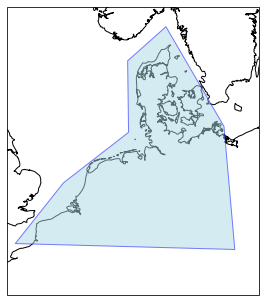

In [7]:
# The WKT representation representing the rough outline of the region of interest 
wktEuroDrought = "Polygon ((0.29 50.07, 3.18 52.53, 7.45 54.49, 7.52 57.24, 10.35 58.47, 13.82 54.49, 13.75 49.64, 0.29 50.07))"
EuroPoly = wkt.loads(wktEuroDrought)

# Curious as you might be, let's make a quick and dirty plot to see how the polygon looks like on a map
mapproj = ccrs.LambertConformal(central_longitude=5, central_latitude=55)
ax = plt.axes([0, 0, 1, 1], projection=mapproj)
ax.set_extent([15, 0, 59, 48])
ax.coastlines()
ax.add_geometries([EuroPoly], crs=ccrs.PlateCarree(), facecolor="lightblue", edgecolor="blue", alpha=0.5)


In [8]:
#Download a subset based upon region and time constraints
withinT = [datetime(2016,1,1), datetime(2018,1,1)]

# load the dataset
soilDset = open_dataset(ds_id=dataset_id, data_store_id=cci_store, time_range=withinT, normalize=True)
#Note if the data has already been downloaded it will not do it again, and this routine will load a lot faster


In [9]:
soilDset

<xarray.Dataset>
Dimensions:         (time: 733, lat: 720, lon: 1440)
Coordinates:
  * lat             (lat) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon             (lon) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time            (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2018-01-02
Data variables:
    dnflag          (time, lat, lon) float32 dask.array<chunksize=(9, 720, 720), meta=np.ndarray>
    flag            (time, lat, lon) float32 dask.array<chunksize=(9, 720, 720), meta=np.ndarray>
    freqbandID      (time, lat, lon) float32 dask.array<chunksize=(9, 720, 720), meta=np.ndarray>
    mode            (time, lat, lon) float32 dask.array<chunksize=(9, 720, 720), meta=np.ndarray>
    sensor          (time, lat, lon) float32 dask.array<chunksize=(9, 720, 720), meta=np.ndarray>
    sm              (time, lat, lon) float32 dask.array<chunksize=(9, 720, 720), meta=np.ndarray>
    sm_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(9, 720, 720), meta=np.ndarray>
    t0              (time, lat, lon) datetime64[ns] dask.array<chunksize=(9, 720, 720), meta=np.ndarray>
Attributes: (12/40)
    Conventions:                CF-1.7
    cdm_data_type:              Grid
    comment:                    This dataset was produced with funding of the...
    contact:                    cci_sm_contact@eodc.eu
    creator_email:              cci_sm_contact@eodc.eu
    creator_name:               Department of Geodesy and Geoinformation, Tec...
    ...                         ...
    time_coverage_duration:     P733D
    time_coverage_end:          2018-01-02T00:00:00
    time_coverage_resolution:   P1D
    time_coverage_start:        2016-01-01T00:00:00
    title:                      ESA CCI Surface Soil Moisture COMBINED active...
    tracking_id:                174f51a4-6a06-4352-a712-4d3f77bd8166

# Step 4 Once we have downloaded the data let's check what we actually got

# Step 5 Let's create monthly aggregates of the data
The data is provided as daily values but for our exercise we would like to create monthly averages (STEP 2 in the workflow). For this we can use the [Cate routine `temporal_aggregation (..)`] (https://cate.readthedocs.io/en/latest/api_reference.html?highlight=aggregation#cate.ops.temporal_aggregation)

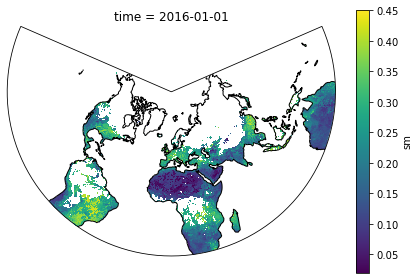

In [10]:
smMonDset = ops.temporal_aggregation(ds=soilDset, method="mean", period="MS")

# select the first time slice of variable "sm" and make a quick and dirty plot (using the xarray routine plot())
p = smMonDset.sm.isel(time=[0]).plot(transform=ccrs.PlateCarree(), subplot_kws={"projection": mapproj})
p.axes.coastlines()

## Questions
1. Try selecting different time slices. 
2. Do you see a general difference between winter and summer?
3. Considering that this is Volumetric Soil Moisture, what does a SM value of 0.25 physically mean?

# Step 6 To identify drought periods we now want to compute the so called *Soil moisture deficit index SMDI*

From the soil moisture we will compute a related severity drought index Soil moisture deficit index (SMDI) 

The SMDI method is defined in STEPS 3, 4 and 5 of figure 2. It is a solution where the soil moisture of the previous month (j-1) is used to calculate the SMDI of the actual month (j). A loop is used to cover the whole series. 

**Variables**

1. ${SMDI}_j$= soil moisture deficit index of the month j
2. ${SMDI}_{j-1}$= SMDI at month j-1 (previous month) 
3. $SD_j$ = monthly soil deficit at month j  
4. $SW_j$ = actual monthly soil moisture at month j.The is the soil moiture map corresponding to a certain map
5. $MSW_j$= long-term monthly **median** available soil water at month j. There will be 12 maps, one per month.
6. $maxSW_j$= long-term monthly **maximum** available soil water at month j. There will be 12 maps, one per month.
7. $minSW_j$ = long-term monthly **minimum** available soil water at month j. There will be 12 maps, one per month.
8. NOTE: $_j-1$ stands for the month previous to month j.

The sequence of the equations are:

1. Calculate: $MSW_j$, $maxSW_j$, $minSW_j$
2. Calculate the monthly soil deficit for the month j
$$SD_j = (SW_j – MSW_j)/(maxSW_j – SW_j) *100,\quad  if SWj > MSWj$$ 
$$SD_j= (SW_j – MSW_j)/(MSW_j – minSW_j)* 100,\quad  if SW_j =< MSW_j$$ 
3. Calculate the soil moisture deficit index dor the month 1 (estimated and initial value)
$SMDI_1 = SD_1/50$  for initial month 
4. Calculate the soil moistiure deficit index for all the other months
$${SMDI}_j= 0.5 * {SMDI}_{j-1}+SD_j/50$$

A SMDI value ranges from -4 to 4 being the negatives indicators of drought. Persistant drought can be detected by monthly accumulation of negatives SMDI giving room to a number of analysis.

In [12]:
# get the median, min and max for all Jan's, Feb's etc.
# we make use of xarray groupby functionality to group the data in months and precompute the median,max and min
smClim = smMonDset.sm.groupby("time.month")

#print(smClim) # uncomment to get additional info
smMed, smMin, smMax = dask.compute(smClim.median(), smClim.min(), smClim.max())


In [13]:
# compute the monthly soil moisture deficit according to Gabi's exercise (note: we split up the computation of SD and SDMI, which will computed later)

# allocate enough data to hold the result (create an xarray.DataArray, and copy the coordinate axes lon,lat,time from the orginal dataset)
# smd = xr.DataArray(np.zeros(smMonDset.sm.shape),name="smd_indx",dims=["time","lat","lon"],coords={"lon":smMonDset.lon,"lat":smMonDset.lat,"time":smMonDset.time})

#Allocate the Soil Moisture deficit index
smdIndex = xr.DataArray(np.zeros(smMonDset.sm.shape), 
                        name="smd_indx",
                        dims=["time","lat","lon"],
                        coords={"lon":smMonDset.lon, "lat":smMonDset.lat, "time":smMonDset.time})
        
start_run_time = datetime.now()
for i,dt in enumerate(smMonDset.time.to_pandas()):
    #Monthly anomaly w.r.t. long term climatological median
    print(f"Compute Soil moisture deficit for {i}, {str(dt)}", end='\r')
    dSm = smMonDset.sm[i,:,:] - smMed[dt.month-1,:,:]
    smMed_m_min = smMed[dt.month-1,:,:] - smMin[dt.month-1,:,:]
    smMax_m_med = smMax[dt.month-1,:,:] - smMed[dt.month-1,:,:]
    smd = 100*xr.where(dSm < 0, dSm/smMed_m_min, dSm/smMax_m_med)
    if i == 0:
        smdIndex[i,:,:] = smd/50
    else:
        smdIndex[i,:,:] = 0.5*smdIndex[i-1,:,:] + smd/50   
print(f'\nTook {datetime.now() - start_run_time}')

Compute Soil moisture deficit for 24, 2018-01-01 00:00:00
Took 0:00:39.284260


# Step 7 Results analysis


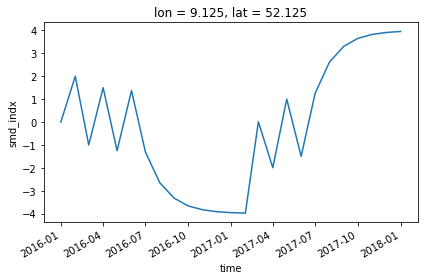

In [14]:
## average over the whole NL

#smdIndexMS=xr.DataArray(np.zeros(48))

#for i,dt in enumerate(smMonDset.time.to_pandas()):
#    #Monthly anomaly w.r.t. long term climatological median
#    smdIndexMS[i]=smdIndex[i,:,:].mean()   

#a_file = open("NL_meanSMDI_2016-2019.txt.txt", "w")
#np.savetxt(a_file, smdIndexMS)

#a_file.close()


# create a simple time series plot of a location
plt.figure()
ilon = 9.0
ilat = 52.0
ploc = smdIndex.sel(lat=ilat, lon=ilon, method="nearest").plot()


Plotting epoch 2017-01-01T00:00:00.000000000


Text(0.5, 1.0, 'Soil moisture deficit index at 2017-01-01T00:00:00')

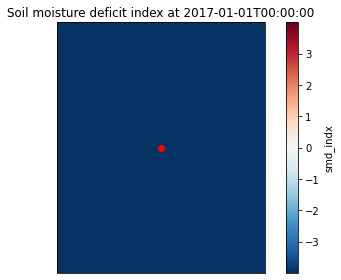

In [30]:
# create a geographical plot at a certain month
it = 12
epoch = smdIndex.time[it].data
print(f"Plotting epoch {str(epoch)}")

ax = plt.subplot(projection=mapproj)
p = smdIndex.sel(time=epoch).plot(ax=ax, transform=ccrs.PlateCarree())

#also plot the location relevant for the plot above
ax.scatter([ilon], [ilat], transform=ccrs.PlateCarree(), color="red")
p.axes.coastlines()
p.axes.set_title(f"Soil moisture deficit index at {np.datetime_as_string(epoch, unit ='s')}")


## Questions

1. You can change the location of the time series. Can you find a location which was severely affected by the 2018 drought?
2. Try changing the month in the geographical plot to a wet and dry month. Explain the differences.
3. Could you identify a period of consecutive negative values of SMDI indicating a severe persistant drought?
4. Do an online search for drought indicators, can you find other types of drought indicators? What data do they ingest?

## Bonus Programming Question (for the python fans)
1. Instead of looking at a single point, can you try to average the SMDI over a region (e.g. select a set of neighbouring gridpoints), and plot that one instead?
2. Try making a matplotlib animation of the SMDI over time


